In [1]:
# Importing necessary models
import warnings
warnings.filterwarnings('ignore')

import smtplib
import pandas as pd
import numpy as np
import datetime as dt
import pandas.stats.moments as st
import time
%matplotlib inline
from bs4 import BeautifulSoup as bs
import requests
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sqlalchemy import *
from sqlalchemy import create_engine
import calendar
import sqlite3 as sql
pd.options.display.float_format = '{:,.3f}'.format

import time
init_notebook_mode(connected=True)

import os
main_dir = os.getcwd()

dbs_dir = 'C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Data\\DBs'

os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Trading\\Modules\\DataCollection')

from alphavantage import *
from yahoo_query import *
from option_slam_earnings import *
from reuters_query import reuters_query, reuters_insiders
from alphaquery import alphaquery

os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Trading\\Modules\\Options')
from optionsFunctions import *

os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Trading\\Modules\\Earnings')
from yahoo_earnings import *
from lookup_earnings import lookup_earnings

os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Trading\\Modules\\Processing')
from hv_calc import *

os.chdir(main_dir)

dbs_dir = 'C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Data\\DBs'

os.chdir(dbs_dir)

earn_engine = create_engine('sqlite:///earningsHistory.db', echo=False)
yahoo_engine = create_engine('sqlite:///yahoo.db', echo = False)
reuters_engine = create_engine('sqlite:///reuters.db', echo=False)

In [2]:
start_time = time.time()

# spyconst = pd.read_excel('https://us.spdrs.com/site-content/xls/SPY_All_Holdings.xls?fund=SPY&docname=All+Holdings&onyx_code1=&onyx_code2=',
#                          skiprows = 3).dropna()

# sector_list = spyconst.Sector.drop_duplicates().tolist()

# key_names = pd.DataFrame(columns = spyconst.columns.tolist())
# for sector in sector_list:
#     if sector != 'Unassigned':
#         curr_sector = spyconst[spyconst.Sector == sector].sort_values('Weight', ascending = False).head(3)
#         key_names = key_names.append(curr_sector)
        
# key_names = key_names.sort_values('Weight', ascending = False).reset_index(drop = True)

key_names = ['MSFT','GOOGL','AMZN','AMD','INTC','NVDA']

aq_dfs = {}

i = 1

for ticker in key_names:#.Identifier[0:]:
    aq_url = 'https://www.alphaquery.com/stock/{}/all-data-variables'.format(ticker)
    s = requests.session()
    curr_aq = bs(s.get(aq_url).text, 'lxml')
    curr_aq = curr_aq.find('table')
    s.cookies.clear()
    key_tables = ['Profile', 'Recent Price/Volume', 'High/Low Price', 'Percent Change in Price', 
                  'Fundamental Ratios', 'Earnings', 'Dividends', 'Percent Growth in Revenue/Net Income',
                  'Percentiles Within Industry of Fundamental Ratios and Percentages',
                  'Percentiles Within Sector of Fundamental Ratios and Percentages']

    for row in curr_aq.find_all('tr'):
        columns = row.find_all('td')

        for col in columns:
            if len(columns) == 1:
                try:
                    if len(curr_df) > 0 and curr_table in key_tables:
                        if type(aq_dfs.get(curr_table, 0)) == int:
                            aq_dfs[curr_table] = curr_df
                        else:
                            aq_dfs[curr_table] = aq_dfs[curr_table].join(curr_df)
                except:
                    pass
                curr_table = col.text
                curr_df = pd.DataFrame(columns = [ticker])
                is_field = True
            else:
                cell_item = col.text.strip().replace(',','')
                if is_field:
                    curr_field = cell_item
                    is_field = False
                else:
                    try:
                        cell_item = float(cell_item)
                    except:
                        pass

                    try:
                        cell_time = dt.datetime.strptime(cell_item, '%Y-%m-%d')
                    except:
                        pass

                    curr_df.loc[curr_field] = cell_item
                    is_field = True
    
    print("{}% Completed".format(round(i*100/len(key_names),2)))
    i += 1
    
print("Completed in {} seconds".format(round(time.time() - start_time, 6)))

16.67% Completed
33.33% Completed
50.0% Completed
66.67% Completed
83.33% Completed
100.0% Completed
Completed in 10.782395 seconds


In [3]:
summary_dfs = {}

for k,v in aq_dfs.items():
    if k == 'Profile':
        summary_dfs[k] = v.T.iloc[:,[1,3,4,5,6,8,9,10]]
        summary_dfs[k].columns = ['Name','Sector','Industry','FreeFloat Mill.','MktCap Bill.','Beta - 60 Months',
                                  'Pct Insiders Held', 'Pct Institutions Held']
        summary_dfs[k] = summary_dfs[k].sort_values('Pct Institutions Held')
        summary_dfs[k]['FreeFloat Mill.'] = pd.to_numeric(summary_dfs[k]['FreeFloat Mill.'])/10**6
        summary_dfs[k]['MktCap Bill.'] = pd.to_numeric(summary_dfs[k]['MktCap Bill.'])/10**9
        
    if k == 'Recent Price/Volume':
        summary_dfs['Prices'] = v.iloc[[0,5],:].T.apply(lambda x: pd.to_numeric(x))
    if k == 'High/Low Price':
        summary_dfs['Prices'] = summary_dfs['Prices'].join(v.T.iloc[:,[0,6,1,7,3,9]])
    if k == 'Percent Change in Price':
        v = v.T.iloc[:,[0,1,3,5]]
        v.columns = ['Return 52 Week','Return 26 Week','Return 4 Week', 'Return 1 Week']
        summary_dfs['Prices'] = summary_dfs['Prices'].join(v).sort_values('Return 1 Week', ascending = False)
    if k == 'Fundamental Ratios':
        v = v.T.iloc[:,:-2]
        v.columns = ['PE Current', 'PE TTM'] + [x.split(' (')[0] for x in v.columns.tolist()[2:]]
        summary_dfs['Fundamentals'] = v.apply(lambda x: pd.to_numeric(x))
    if k == 'Earnings':
        v = v.T.iloc[:,[1,2,5,6,8,9,10]]
        v.columns = ['Quarterly EPS Estimate','Next Earnings','Last EPS Estimate', 
                     'Last EPS',' Days Since Last Earnings','Recent FY EPS', 'Diluted EPS TTM']
        summary_dfs['Earnings'] = v
        
    if k == 'Dividends':
        v = v.tail(1).T
        v.columns = ['Div Yield']
        summary_dfs['Fundamentals'] = summary_dfs['Fundamentals'].join(v)
        
    if k == 'Percent Growth in Revenue/Net Income':
        v = v.T
        v.columns = [x.replace('Percent Growth in ', 'Change % ').replace('Quarterly','Qtr').replace('Revenue', 'Rev').replace('Income','Inc') for x in v.columns.tolist()]
        summary_dfs['Earnings'] = summary_dfs['Earnings'].join(v).sort_values('Change % Annual Rev', ascending = False)
    if k == 'Percentiles Within Industry of Fundamental Ratios and Percentages':
        v = v.T.iloc[:,[1]].apply(lambda x: pd.to_numeric(x))
        v.columns = ['TTM PE Industry Percentile']
        summary_dfs['Target Prices'] = summary_dfs['Prices'][['Closing Price']].join(summary_dfs['Fundamentals'][['PE TTM']]).join(summary_dfs['Earnings'][['Diluted EPS TTM']]).sort_values('PE TTM', ascending = False)
        summary_dfs['Target Prices'] = summary_dfs['Target Prices'].join(v)
    if k == 'Percentiles Within Sector of Fundamental Ratios and Percentages':
        v = v.T.iloc[:,[1]].apply(lambda x: pd.to_numeric(x))
        v.columns = ['TTM PE Sector Percentile']
        summary_dfs['Target Prices'] = summary_dfs['Target Prices'].join(v)
        
summary_dfs['Target Prices']['Steal Price'] = 0.7*summary_dfs['Target Prices']['PE TTM']*summary_dfs['Target Prices']['Diluted EPS TTM']*0.9

In [6]:
summary_table = pd.concat([summary_dfs['Prices'].iloc[:,:2].T, 
                           summary_dfs['Target Prices'][['Steal Price']].T, 
                           summary_dfs['Profile'].T], axis = 0)

summary_table

,AMD,AMZN,GOOGL,INTC,MSFT,NVDA
Closing Price,26.000,"1,761.850","1,202.460",54.170,117.650,175.710
Previous Closing Price,23.250,"1,742.150","1,188.550",54.100,117.570,168.950
Steal Price,13.392,"1,097.492",688.826,33.276,73.910,119.626
Name,Advanced Micro Devices Inc.,Amazon.com Inc.,Alphabet Inc.,Intel Corporation,Microsoft Corporation,NVIDIA Corporation
Sector,Technology,Consumer Cyclical,Technology,Technology,Technology,Technology
Industry,Semiconductors,Specialty Retail,Internet Content & Information,Semiconductors,Software - Infrastructure,Semiconductors
FreeFloat Mill.,987.204,411.137,603.421,"4,676.914","7,593.536",577.518
MktCap Bill.,23.373,855.749,826.263,253.097,905.265,102.384
Beta - 60 Months,3.400,1.620,1.050,0.790,1.210,1.890
Pct Insiders Held,1.800,16.300,13.200,0.030,1.380,4.700


In [7]:
detail_table = pd.concat([summary_dfs['Prices'].T,
                          summary_dfs['Fundamentals'].T,
                          summary_dfs['Earnings'].T], axis = 0).iloc[2:]
detail_table

,AMD,AMZN,GOOGL,INTC,MSFT,NVDA
52-Week High Price,34.140,"2,050.500","1,291.440",56.530,118.440,291.860
52-Week Low Price,9.040,"1,307.000",977.660,41.830,85.620,124.330
26-Week High Price,33.600,"2,033.190","1,224.520",54.690,118.440,291.860
26-Week Low Price,16.030,"1,307.000",977.660,41.830,93.560,124.330
4-Week High Price,26.080,"1,784.160","1,207.120",54.690,118.440,177.500
4-Week Low Price,21.040,"1,586.570","1,097.980",51.060,106.290,144.800
Return 52 Week,134.020,11.050,9.730,7.670,28.480,-29.300
Return 26 Week,-18.570,-9.230,3.030,19.000,4.830,-34.970
Return 4 Week,8.560,8.250,6.740,5.390,9.230,12.290
Return 1 Week,10.690,5.300,0.440,1.120,3.550,8.120


In [10]:
mgaain = []

start_date = dt.datetime(2005,1,1)

for ticker in key_names:
    curr_prices = yahoo_query(ticker,start_date)
    curr_prices.hist_prices_query()
    mgaain.append(curr_prices.hist_prices)

In [52]:
mgaain_df = pd.concat(mgaain, axis = 1)
mgaain_prices = mgaain_df[list(filter(lambda x: '_adjclose' in x, mgaain_df.columns.tolist()))]

mgaain_prices.columns = [x.replace('_adjclose','') for x in mgaain_prices.columns.tolist()]

weights = pd.to_numeric(summary_table.loc['MktCap Bill.'])
weights = weights/weights.sum()

mgaain_index = mgaain_prices.dot(pd.DataFrame(weights))
mgaain_index.columns = ['MGAAIN_Price']
mgaain_index['Cumulative_Return'] = mgaain_index/mgaain_index.iloc[0,0] - 1

spx = yahoo_query('^GSPC',start_date)
spx.hist_prices_query()
spx = spx.hist_prices
spx_close = spx[['^GSPC_adjclose']]
spx_close['SPX_Cumulative_Return'] = spx_close/spx_close.iloc[0,0] - 1

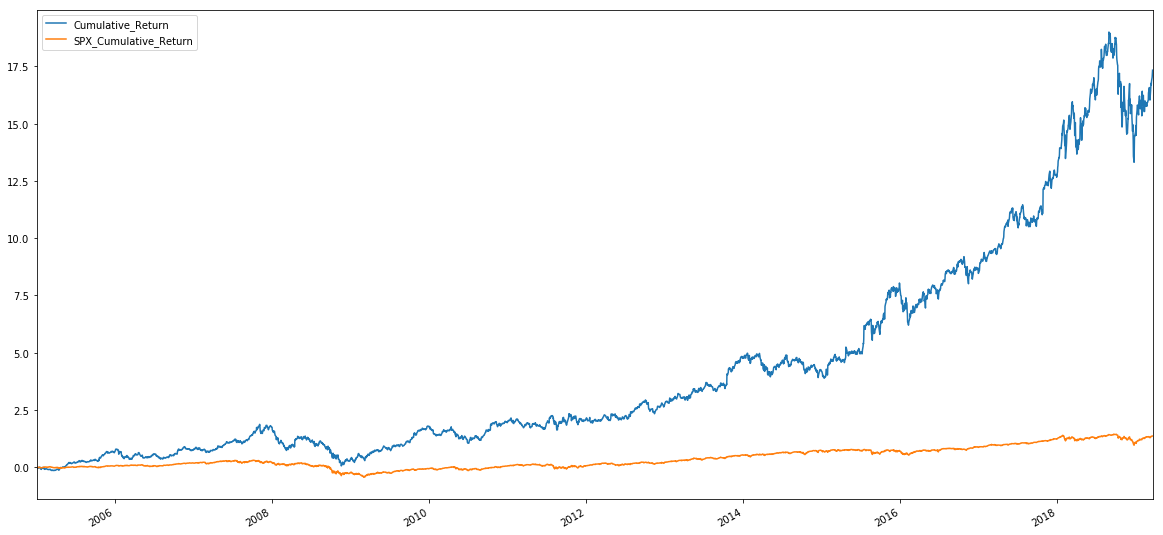

In [56]:
pd.concat([mgaain_index['Cumulative_Return'],spx_close['SPX_Cumulative_Return']], axis = 1).plot(figsize = (20,10))


In [61]:
mgaain_prices.tail()

,MSFT,GOOGL,AMZN,AMD,INTC,NVDA
2019-03-14,114.590,"1,192.530","1,686.220",22.820,53.440,165.560
2019-03-15,115.910,"1,190.300","1,712.360",23.290,54.330,169.810
2019-03-18,117.570,"1,188.550","1,742.150",23.250,54.100,168.950
2019-03-19,117.650,"1,202.460","1,761.850",26.000,54.170,175.710
2019-03-20,117.180,"1,211.040","1,772.299",25.655,53.820,173.150


In [70]:
round(weights*500000/mgaain_prices.tail()/100,0)

,AMD,AMZN,GOOGL,INTC,MSFT,NVDA
2019-03-14,2.000,1.000,1.000,8.000,13.000,1.000
2019-03-15,2.000,1.000,1.000,8.000,13.000,1.000
2019-03-18,2.000,1.000,1.000,8.000,13.000,1.000
2019-03-19,2.000,1.000,1.000,8.000,13.000,1.000
2019-03-20,2.000,1.000,1.000,8.000,13.000,1.000


In [71]:
summary_table

,AMD,AMZN,GOOGL,INTC,MSFT,NVDA
Closing Price,26.000,"1,761.850","1,202.460",54.170,117.650,175.710
Previous Closing Price,23.250,"1,742.150","1,188.550",54.100,117.570,168.950
Steal Price,13.392,"1,097.492",688.826,33.276,73.910,119.626
Name,Advanced Micro Devices Inc.,Amazon.com Inc.,Alphabet Inc.,Intel Corporation,Microsoft Corporation,NVIDIA Corporation
Sector,Technology,Consumer Cyclical,Technology,Technology,Technology,Technology
Industry,Semiconductors,Specialty Retail,Internet Content & Information,Semiconductors,Software - Infrastructure,Semiconductors
FreeFloat Mill.,987.204,411.137,603.421,"4,676.914","7,593.536",577.518
MktCap Bill.,23.373,855.749,826.263,253.097,905.265,102.384
Beta - 60 Months,3.400,1.620,1.050,0.790,1.210,1.890
Pct Insiders Held,1.800,16.300,13.200,0.030,1.380,4.700
